### First attempt sticking grizli output into PostgreSQL tables

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML

import pandas as pd
pd.set_option('display.max_colwidth', -1)

from grizli import utils, __version__
from grizli.aws import db as grizli_db

print('Grizli version: ', __version__)
utils.set_warnings()

Grizli version:  1.0-22-g93c27d5


### postgresql tables on AWS RDS

I've started dumping information into `postgresql` tables and the potential seems awesome, even for my hacky database layout.  

**How does one set this up on TAP / ADQL??**

In [3]:
# readonly DB access
config = {'hostname': 'grizdbinstance.c3prl6czsxrm.us-east-1.rds.amazonaws.com',
 'username': 'redshift_fit_public',
 'password': 'EMAIL gbrammer FOR PASSWORD',
 'database': 'grizlifields',
 'port': 5432}

# sqlalchemy engine for postgresql
engine = grizli_db.get_db_engine(config=config)
print('Tables: ', engine.table_names()

/Users/gbrammer/miniconda3/envs/grizli-dev/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Tables:  ['z_spec_tmp', 'redshift_fit', 'charge_fields', 'xmm_dr8', 'survey_fields', 'observation', 'field_observation', 'photometry_apcorr', 'photometry_detect']


### Redshift fit status flags from the fits run on Lambda

`redshift_fit.status`:

  **`3`** - The object should have an extracted `beams.fits` file in the S3 filesystem

  **`5`** - extractions and redshift fits that timed out in the 15 minute Lambda limit, 
            e.g., some deep pointings or unconstrained fits that find many peaks on the second pass

  **`6`** : completed redshift fits with full information stored in the `redshift_fit` table.


In [4]:
print(grizli_db.FLAGS)

{'init_lambda': 1, 'start_beams': 2, 'done_beams': 3, 'no_run_fit': 4, 'start_redshift_fit': 5, 'fit_complete': 6}


In [5]:
for table in ['charge_fields', 'photometry_apcorr', 'redshift_fit']:
    photom = pd.read_sql_query('select * from {0} where false;'.format(table), engine)
    cols = list(photom.columns)
    count = pd.read_sql_query('select count(*) as n from {0};'.format(table), engine)
    
    print('###  Table `{0}`: {1} rows x {2} columns   ###\n' .format(table, 
                                                    count['n'][0], len(photom.columns)))
    
    r, c = 6, 10
    for i in range(c):
        print('   '+', '.join(['{0:10}'.format(ci) for ci in cols[i*r:(i+1)*r]]))
    print('    ...\n')      

###  Table `charge_fields`: 2502 rows x 377 columns   ###

   qtime     , boxra     , boxdec    , boxrad    , obsquery  , field_root
   field_ra  , field_dec , mw_ebv    , folap     , min_area  , buffer    
   field_xmin, field_xmax, field_ymin, field_ymax, boxquery  , nassoc    
   ecllat    , ecllon    , gallat    , gallon    , nfilt     , filter    
   target    , target_classification, proposal_id, proposal_pi, ng102     , areag102  
   texpg102  , tperg102  , pag102    , ng141     , areag141  , texpg141  
   tperg141  , pag141    , ng800l    , areag800l , texpg800l , tperg800l 
   pag800l   , ng280     , areag280  , texpg280  , tperg280  , pag280    
   mast      , footprint , skip      , has_wfc3ir, comment   , gaia5     
   t_acs_wfc_clear1l_f814w, wh_acs_wfc_clear1l_f814w, a_acs_wfc_clear1l_f814w, t_acs_wfc_f435w, wh_acs_wfc_f435w, a_acs_wfc_f435w
    ...

###  Table `photometry_apcorr`: 1910827 rows x 1300 columns   ###

   thresh    , npix      , tnpix     , image_xmin, image

## Example query: z_grism vs z_spec

Here z_specs are taken from a large variety of literature sources.
I've taken separate tables and matched them into the `photometry_apcorr` database, but 
this would better be done with a separate z_spec table in the database.

The `make_html_table` function below automatically does a join on `redshift_fit` and `photometry_apcorr` based on the object `root` + `id` combinations.

If you don't set `get_sql=True`, it makes a sortable HTML table like the link below sends it to the S3 target specified in `sync`.

### Full table: https://s3.amazonaws.com/grizli-v1/tables/zspec_delta.html?&status_min=5.5


In [6]:
SQLtxt = grizli_db.make_html_table(engine=engine, 
                   columns=['root','status','id','ra','dec','mag_auto','flux_radius',
                            'z_spec','z_map','z_spec_src','bic_diff','chinu','log_pdf_max', 
                            'zwidth1/(1+z_map) as zw1','(z_map-z_spec)/(1+z_spec) as dz'], 
                   where="AND status > 4 AND z_spec > 0 AND z_spec_qual = 1 AND z_spec_src NOT LIKE '%%Caminha%%'", 
                   table_root='zspec_delta', sync='s3://grizli-v1/tables/', 
                   png_ext=['R30', 'stack','full','line'], get_sql=True)

print(SQLtxt.replace('FROM','\n    FROM').replace('WHERE','\n    WHERE'))

# Below is like `pd.read_sql_query` but sends result 
# to an astropy table rather than a `DataFrame`
res = grizli_db.from_sql(SQLtxt, engine)

SELECT root,status,id,ra,dec,mag_auto,flux_radius,z_spec,z_map,z_spec_src,bic_diff,chinu,log_pdf_max,zwidth1/(1+z_map) as zw1,(z_map-z_spec)/(1+z_spec) as dz 
    FROM photometry_apcorr, redshift_fit 
    WHERE root = p_root AND id = p_id AND status > 4 AND z_spec > 0 AND z_spec_qual = 1 AND z_spec_src NOT LIKE '%%Caminha%%';


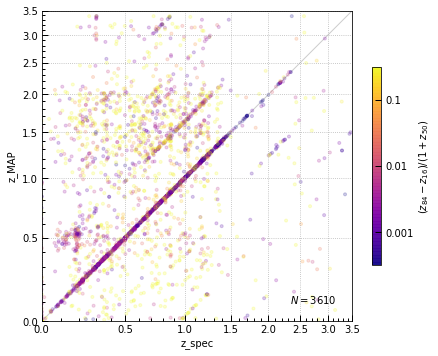

In [7]:
# z_grism vs z_spe c
from matplotlib.ticker import FixedLocator, AutoLocator, MaxNLocator

# Pseudolog in log(1+z)
xti = xt = np.arange(0,3.6,0.5)
loc = np.arange(0, 3.6, 0.1)

fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)

kwargs = {'marker':'.', 'vmin':-3.5, 'vmax': -0.5, 'cmap': 'plasma'}

ax.scatter(np.log(1+res['z_spec']), np.log(1+res['z_map']), alpha=0.2, 
           c=np.log10(res['zw1']), **kwargs)

# dummy replot for darker colorbar
sc = ax.scatter(np.log([1]), np.log([1]), alpha=0.8, c=[0], **kwargs)
cb = plt.colorbar(sc, shrink=0.6)
cb.set_label(r'$(z_{84}-z_{16})/(1+z_{50})$')
cb.set_ticks([-3,-2,-1])
cb.set_ticklabels([0.001, 0.01, 0.1])

xts = ax.set_xticks(np.log(1+xt))
xtl = ax.set_xticklabels(xti)
xts = ax.set_yticks(np.log(1+xt))
xtl = ax.set_yticklabels(xti)

ax.set_xlim(0, np.log(1+3.5))
ax.set_ylim(0, np.log(1+3.5))

ax.xaxis.set_minor_locator(FixedLocator(np.log(1+loc)))                                                                                                                                          
ax.yaxis.set_minor_locator(FixedLocator(np.log(1+loc)))      

ax.set_xlabel('z_spec')
ax.set_ylabel('z_MAP')

ax.set_aspect(1)
ax.grid()
ax.text(0.95, 0.05, r'$N={0}$'.format(len(res)), ha='right', va='bottom', 
        transform=ax.transAxes)

ax.plot(ax.get_xlim(), ax.get_xlim(), color='k', 
        alpha=0.2, linewidth=1, zorder=-10)

fig.tight_layout(pad=0.1)

In [8]:
# z_spec references
SQL = """
SELECT * FROM (SELECT z_spec_src, count(z_spec_src) AS n FROM photometry_apcorr 
    WHERE z_spec_qual = 1 AND z_spec_src NOT LIKE '%%Caminha%%' GROUP BY z_spec_src) foo ORDER BY n DESC;
"""
counts = grizli_db.from_sql(SQL, engine)

In [9]:
counts[0:20]

z_spec_src,n
str30,int64
deep2-dr4,2276
Damjanov 2018,713
sdss-dr15-GALAXY,653
sparcs,645
Owers 2011a,340
vipers-dr2-w1,317
sdss-dr15-QSO,262
AGES Kochanek,239
Ruel 2014,225


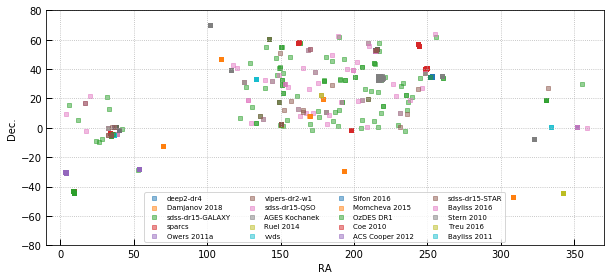

In [10]:
# Show where the sources are on the sky
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)

for src in counts['z_spec_src'][0:20]:
    sub = res['z_spec_src'] == src
    ax.scatter(res['ra'][sub], res['dec'][sub], marker='s', s=20, 
               label=src, alpha=0.5)

ax.set_aspect(1)
ax.set_xlim(-10, 370); ax.set_ylim(-80, 80)
ax.set_xlabel('RA'); ax.set_ylabel('Dec.')
ax.grid()
ax.legend(loc='lower center', fontsize=7, ncol=4)

In [11]:
# Individual object: high-z quasar
SQLtxt = grizli_db.make_html_table(engine=engine, 
                                columns=['status','root','id','ra','dec','mag_auto','flux_radius',
                                         'z_spec','z_map','z_spec_src'], 
                                where="AND status > 4 AND z_spec > 6.0 AND z_spec_qual = 1",  get_sql=True)

print(SQLtxt.replace('FROM','\n    FROM').replace('WHERE','\n    WHERE'))

# `from_sql` is like `pd.read_sql_query` but sends result 
# to an astropy table rather than a `DataFrame`
highz = grizli_db.from_sql(SQLtxt, engine)

SELECT status,root,id,ra,dec,mag_auto,flux_radius,z_spec,z_map,z_spec_src 
    FROM photometry_apcorr, redshift_fit 
    WHERE root = p_root AND id = p_id AND status > 4 AND z_spec > 6.0 AND z_spec_qual = 1;


In [12]:
highz

status,root,id,ra,dec,mag_auto,flux_radius,z_spec,z_map,z_spec_src
int64,str12,int64,float64,float64,float64,float64,float64,float64,str20
6,j142952p5447,719,217.46700,54.78820,20.55,1.2,6.210,6.172,Wang 2016 high-z QSO


In [14]:
HTML(grizli_db.render_for_notebook(highz['root','id','ra','dec','mag_auto','z_spec','z_map'], 
                                   image_extensions=['stack','full']))

,root,id,ra,dec,mag_auto,z_spec,z_map,stack,full
0,j142952p5447,719,217.467,54.7882,20.549747,6.21,6.17207,,


In [15]:
# SDSS quasars
qso = (res['z_spec_src'] == 'sdss-dr15-QSO')
print('{0} SDSS QSOs'.format(qso.sum()))
arc = (res['z_spec_src'] == 'Rigby 2018')
print('{0} Megasaura arc images'.format(arc.sum()))

71 SDSS QSOs
4 Megasaura arc images


In [16]:
HTML(grizli_db.render_for_notebook(res[arc]['root','id','ra','dec','mag_auto','z_spec','z_map'], 
                                   image_extensions=['stack','full','line']))

,root,id,ra,dec,mag_auto,z_spec,z_map,stack,full,line
0,j032728m1326,1476,51.8665,-13.4359,20.665002,1.703400,1.70635,,,
1,j032728m1326,1475,51.8675,-13.4368,20.096246,1.703884,1.70493,,,
2,j032728m1326,1477,51.8657,-13.4355,20.994835,1.703600,1.70429,,,
3,j032728m1326,815,51.8632,-13.4484,21.165216,1.703070,1.70306,,,
